In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR


import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

from statsmodels.tsa.stattools import grangercausalitytests, adfuller

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [154]:
# p-value <= 0.05 means data is stationary
def adfullerTest():
    for column in columns:
        result = adfuller(column)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

        print("-----------------------------------")

In [134]:
D001_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D001_data.csv')
D001_df = D001_df.iloc[913:]
D001_df
D001_df['time'] =  pd.to_datetime(D001_df['time'], format='%Y-%m-%d %H:%M:%S')
D001_df.index = D001_df['time']
D001_df = D001_df.drop(['time','H','P','CO2'],axis = 1)

In [135]:
D001_df['T'] = D001_df['T'].diff().ffill().backfill()

In [136]:
train_data, test_data = train_test_split(D001_df, test_size=0.2, shuffle=False)

### If p < 0.5, there is a correlation

In [137]:
maxGrangerLag = 12

In [138]:
print('Temperature causes Radon?\n')
print('------------------')
temperatureRadonGranger = grangercausalitytests(D001_df[['Rn', 'T']], maxGrangerLag)

Temperature causes Radon?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0097  , p=0.3150  , df_denom=8543, df_num=1
ssr based chi2 test:   chi2=1.0101  , p=0.3149  , df=1
likelihood ratio test: chi2=1.0100  , p=0.3149  , df=1
parameter F test:         F=1.0097  , p=0.3150  , df_denom=8543, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3122  , p=0.0991  , df_denom=8540, df_num=2
ssr based chi2 test:   chi2=4.6271  , p=0.0989  , df=2
likelihood ratio test: chi2=4.6259  , p=0.0990  , df=2
parameter F test:         F=2.3122  , p=0.0991  , df_denom=8540, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4415  , p=0.0623  , df_denom=8537, df_num=3
ssr based chi2 test:   chi2=7.3305  , p=0.0621  , df=3
likelihood ratio test: chi2=7.3273  , p=0.0622  , df=3
parameter F test:         F=2.4415  , p=0.0623  , df_denom=8537, df_num=3

Granger Causality
number of lags (no zero

In [139]:
# print('Humidity causes Radon?\n')
# print('------------------')
# temperatureRadonGranger = grangercausalitytests(D001_df[['Rn', 'H']], maxGrangerLag)

In [140]:
# print('Pressure causes Radon?\n')
# print('------------------')
# temperatureRadonGranger = grangercausalitytests(D001_df[['Rn', 'P']], maxGrangerLag)

In [141]:
# print('CO2 causes Radon?\n')
# print('------------------')
# temperatureRadonGranger = grangercausalitytests(D001_df[['Rn', 'CO2']], maxGrangerLag)

In [142]:
maxlags=34
model = VAR(D001_df)
model_order = model.select_order(maxlags)
model_order.summary()

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,9.013,9.015,8210.,9.014
1,7.015,7.020,1113.,7.017
2,6.967,6.975,1061.,6.970
3,6.925,6.936,1017.,6.928
4,6.922,6.937,1014.,6.927
5,6.816,6.835,912.7,6.823
6,6.812,6.834,908.7,6.819
7,6.811,6.836,908.0,6.820
8,6.807,6.835,903.9,6.816
9,6.784,6.816,883.8,6.795


In [143]:
lags = 7
model_fitted= model.fit(lags)

In [144]:
lag_order = model_fitted.k_ar
print(lag_order)

7


In [145]:
forecast_input = train_data.values[-lag_order:]
print(forecast_input )

[[ 9.91666667e-02  3.47397500e+02]
 [-9.40909091e-02  3.75615455e+02]
 [-4.26742424e-01  3.61025000e+02]
 [-1.40833333e-01  3.47488333e+02]
 [ 4.84848485e-02  3.27105455e+02]
 [-1.23484848e-01  3.20598333e+02]
 [-4.16666667e-02  3.04630000e+02]]


In [146]:
nobs = len(test_data)
# print(nobs)
# print(forecast_input)

In [147]:
forecast = model_fitted.forecast(y=forecast_input,steps = nobs)

In [148]:
forecast

array([[ 1.99710792e-02,  3.02121675e+02],
       [ 1.70196152e-02,  3.09189569e+02],
       [ 1.10564209e-02,  3.07940097e+02],
       ...,
       [-1.13997635e-03,  2.60323822e+02],
       [-1.13997635e-03,  2.60323822e+02],
       [-1.13997635e-03,  2.60323822e+02]])

In [149]:
forecast_df= pd.DataFrame(forecast,index=test_data.index, columns=test_data.columns)

In [150]:
test_data

,T,Rn
time,,
2021-05-13 18:00:00,1.278333,912.045000
2021-05-13 19:00:00,-0.097500,853.960000
2021-05-24 22:00:00,-0.932500,90.156667
2021-05-25 00:00:00,0.684000,68.766000
2021-05-25 01:00:00,-0.156273,79.580000
...,...,...
2021-08-18 08:00:00,0.047556,145.034000
2021-08-18 09:00:00,-0.107000,226.328000
2021-08-18 10:00:00,0.038750,247.572500


In [151]:
forecast_df

,T,Rn
time,,
2021-05-13 18:00:00,0.019971,302.121675
2021-05-13 19:00:00,0.017020,309.189569
2021-05-24 22:00:00,0.011056,307.940097
2021-05-25 00:00:00,-0.001585,306.733560
2021-05-25 01:00:00,0.001783,304.953795
...,...,...
2021-08-18 08:00:00,-0.001140,260.323822
2021-08-18 09:00:00,-0.001140,260.323822
2021-08-18 10:00:00,-0.001140,260.323822


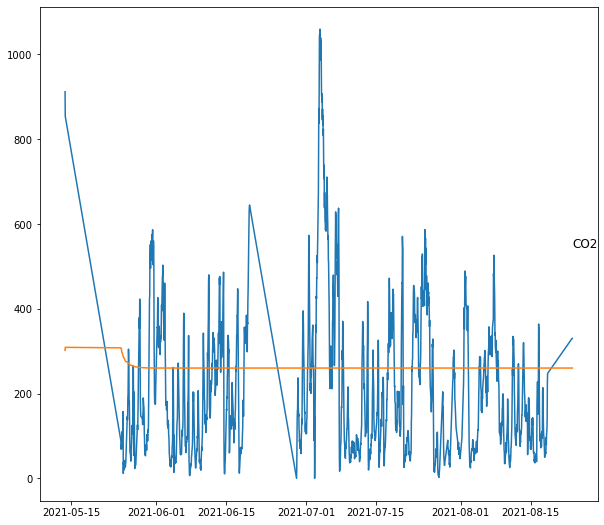

In [152]:
no_cols = len(test_data.columns)

index = 1

plt.figure(figsize=(10,20))
# for column in test_data.columns:
plt.subplot(no_cols,1,index)
plt.plot(test_data['Rn'])
plt.plot(forecast_df['Rn'])
plt.title(column,loc='right',y=0.5)

plt.show()